In [10]:
# Acciones3 Notebook





In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [4]:
# ML Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
def descargar_datos_bmv(tickers, periodo="1y"):
    """
    Descarga datos históricos de múltiples tickers de BMV usando yfinance

    Args:
        tickers (list): Lista de tickers BMV (ej: ['FEMSAUBD.MX', 'GAPB.MX'])
        periodo (str): Período de datos (ej: '1y', '2y', '5y')

    Returns:
        dict: Diccionario con DataFrames de cada ticker
    """
    import yfinance as yf
    datos = {}

    for ticker in tickers:
        print(f"Descargando {ticker} …")

        # Descargar datos históricos usando yfinance
        ticker_data = yf.Ticker(ticker)
        df = ticker_data.history(period=periodo, auto_adjust=True)

        # Resetear índice y renombrar columnas
        df.reset_index(inplace=True)
        df.rename(columns={
            "Date": "FECHA",
            "Open": "OPEN",
            "High": "HIGH",
            "Low": "LOW",
            "Close": "CLOSE",
            "Volume": "VOLUME"
        }, inplace=True)

        # Seleccionar y ordenar columnas
        df = df[["FECHA", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]]
        df["FECHA"] = pd.to_datetime(df["FECHA"]).dt.strftime("%Y-%m-%d")
        df.sort_values("FECHA", inplace=True)

        # Guardar como CSV
        archivo_csv = f"{ticker.replace('.MX', '')}.csv"
        df.to_csv(archivo_csv, index=False, float_format="%.4f")

        datos[ticker] = df
        print(f"Listo → {archivo_csv}  ({len(df)} filas)")

    return datos

In [7]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
class TradingBotML:
    def __init__(self, data_path=None, dataframe=None, tickers=None, periodo="max", mode="individual"):
        """
        Initialize the trading bot with data

        Args:
            data_path (str): Path to CSV file
            dataframe (DataFrame): DataFrame with historical data
            tickers (list): List of BMV tickers with .MX suffix for automatic download
            periodo (str): Period for data download ('max', '1y', '2y', etc.)
            mode (str): 'individual' para análisis por ticker o 'combined' para análisis conjunto
        """
        self.mode = mode
        self.ticker_data = {}
        self.combined_data = None

        if data_path:
            self.df = pd.read_csv(data_path)
            self.mode = "individual"
        elif dataframe is not None:
            self.df = dataframe.copy()
            self.mode = "individual"
        elif tickers is not None:
            # Descargar datos automáticamente si se proporcionan tickers
            print(f"Descargando datos para {len(tickers)} tickers...")
            datos_descargados = descargar_datos_bmv(tickers, periodo)

            if mode == "individual":
                # Guardar datos individuales por ticker
                self.ticker_data = datos_descargados
                print(f"Datos individuales guardados para {len(self.ticker_data)} tickers")
            else:
                # Combinar todos los datos en un solo DataFrame
                dataframes = []
                for ticker, df_ticker in datos_descargados.items():
                    df_ticker['TICKER'] = ticker.replace('.MX', '')
                    dataframes.append(df_ticker)

                self.df = pd.concat(dataframes, ignore_index=True)
                print(f"Datos combinados: {len(self.df)} filas")
        else:
            raise ValueError("Debe proporcionar data_path, dataframe o tickers")

        self.scaler = MinMaxScaler()
        self.features = None
        self.models = {}
        self.predictions = {}
        self.individual_results = {}

        if self.mode == "individual" and hasattr(self, 'ticker_data'):
            # Preparar datos individuales para cada ticker
            self.prepare_individual_data()
        elif self.mode == "combined" and hasattr(self, 'df'):
            # Preparar datos combinados
            self.prepare_data()
        elif hasattr(self, 'df'):
            # Preparar datos para un solo DataFrame
            self.prepare_data()

    def prepare_data(self):
        """Preprocess the raw trading data"""
        # Convert date column
        self.df['FECHA'] = pd.to_datetime(self.df['FECHA'])
        self.df = self.df.sort_values('FECHA')
        self.df.reset_index(drop=True, inplace=True)

        # Handle N/A values in volume
        self.df['VOLUME'] = pd.to_numeric(self.df['VOLUME'], errors='coerce')
        self.df['VOLUME'].fillna(method='ffill', inplace=True)

        # Create basic features
        self.df['returns'] = self.df['CLOSE'].pct_change()
        self.df['high_low_pct'] = (self.df['HIGH'] - self.df['LOW']) / self.df['CLOSE']
        self.df['price_change'] = self.df['CLOSE'] - self.df['OPEN']
        self.df['intraday_momentum'] = (self.df['CLOSE'] - self.df['OPEN']) / (self.df['HIGH'] - self.df['LOW'])

        # Technical indicators
        self.add_technical_indicators()

        # Remove NaN values and infinities
        self.df = self.df.replace([np.inf, -np.inf], np.nan)
        self.df.dropna(inplace=True)

        # Verificar que no quedan valores infinitos o muy grandes
        self.check_data_quality()

    def prepare_individual_data(self):
        """Preprocess data for each ticker individually"""
        for ticker, df in self.ticker_data.items():
            print(f"Preparando datos para {ticker}...")

            # Convert date column
            df['FECHA'] = pd.to_datetime(df['FECHA'])
            df = df.sort_values('FECHA')
            df.reset_index(drop=True, inplace=True)

            # Handle N/A values in volume
            df['VOLUME'] = pd.to_numeric(df['VOLUME'], errors='coerce')
            df['VOLUME'].fillna(method='ffill', inplace=True)

            # Create basic features
            df['returns'] = df['CLOSE'].pct_change()
            df['high_low_pct'] = (df['HIGH'] - df['LOW']) / df['CLOSE']
            df['price_change'] = df['CLOSE'] - df['OPEN']
            df['intraday_momentum'] = (df['CLOSE'] - df['OPEN']) / (df['HIGH'] - df['LOW'])

            # Technical indicators
            self.add_technical_indicators_to_df(df)

            # Remove NaN values and infinities
            df = df.replace([np.inf, -np.inf], np.nan)
            df.dropna(inplace=True)

            # Guardar datos procesados
            self.ticker_data[ticker] = df

    def check_data_quality(self):
        """Check for data quality issues"""
        # Verificar valores infinitos
        inf_count = np.isinf(self.df.select_dtypes(include=[np.number])).sum().sum()
        if inf_count > 0:
            print(f"ADVERTENCIA: Se encontraron {inf_count} valores infinitos. Han sido reemplazados por NaN.")

        # Verificar valores muy grandes
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if self.df[col].abs().max() > 1e10:
                print(f"ADVERTENCIA: La columna {col} contiene valores muy grandes. Considera normalizar los datos.")

    def add_technical_indicators(self):
        """Add technical analysis indicators to self.df"""
        self.add_technical_indicators_to_df(self.df)

    def add_technical_indicators_to_df(self, df):
        """Add technical analysis indicators to a DataFrame"""
        # Simple Moving Averages
        for window in [5, 10, 20]:
            df[f'sma_{window}'] = df['CLOSE'].rolling(window=window).mean()
            df[f'sma_ratio_{window}'] = df['CLOSE'] / df[f'sma_{window}']

        # Exponential Moving Averages
        for window in [12, 26]:
            df[f'ema_{window}'] = df['CLOSE'].ewm(span=window).mean()

        # MACD
        df['macd'] = df['ema_12'] - df['ema_26']
        df['macd_signal'] = df['macd'].ewm(span=9).mean()

        # RSI
        delta = df['CLOSE'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))

        # Bollinger Bands
        bb_window = 20
        df['bb_middle'] = df['CLOSE'].rolling(window=bb_window).mean()
        bb_std = df['CLOSE'].rolling(window=bb_window).std()
        df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
        df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
        df['bb_position'] = (df['CLOSE'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

    def create_features(self, lookback=20, forecast_horizon=1):
        """Create features for ML models"""
        if self.mode == "individual" and hasattr(self, 'ticker_data'):
            # Crear características para cada ticker individualmente
            for ticker, df in self.ticker_data.items():
                print(f"Creando características para {ticker}...")
                self.create_features_for_ticker(ticker, df, lookback, forecast_horizon)
        else:
            # Crear características para datos combinados
            self.create_features_for_combined(lookback, forecast_horizon)

    def create_features_for_ticker(self, ticker, df, lookback=20, forecast_horizon=1):
        """Create features for a specific ticker"""
        feature_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME',
                       'returns', 'high_low_pct', 'price_change', 'intraday_momentum',
                       'sma_5', 'sma_10', 'sma_20', 'macd', 'macd_signal', 'rsi',
                       'bb_position', 'bb_upper', 'bb_lower']

        # Remove any columns that might not exist
        feature_cols = [col for col in feature_cols if col in df.columns]

        # Create sequences for time series
        X, y = [], []

        for i in range(lookback, len(df) - forecast_horizon + 1):
            # Features: last 'lookback' days
            X.append(df[feature_cols].iloc[i-lookback:i].values.flatten())

            # Target: next day's return
            future_price = df['CLOSE'].iloc[i + forecast_horizon - 1]
            current_price = df['CLOSE'].iloc[i-1]
            y.append((future_price - current_price) / current_price)

        X = np.array(X)
        y = np.array(y)

        # Verificar y limpiar datos
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

        # Limitar valores extremos
        X = np.clip(X, -1e10, 1e10)
        y = np.clip(y, -1.0, 1.0)

        # Create classification target
        y_class = (y > 0).astype(int)

        # Split data chronologically (80% train, 20% test)
        split_idx = int(0.8 * len(X))
        X_train = X[:split_idx]
        X_test = X[split_idx:]
        y_train = y[:split_idx]
        y_test = y[split_idx:]
        y_train_class = y_class[:split_idx]
        y_test_class = y_class[split_idx:]

        # Scale features
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Store data for this ticker
        self.ticker_data[ticker] = {
            'df': df,
            'X': X,
            'y': y,
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'y_train_class': y_train_class,
            'y_test_class': y_test_class,
            'X_train_scaled': X_train_scaled,
            'X_test_scaled': X_test_scaled,
            'scaler': scaler,
            'test_indices': df.index[split_idx + lookback:len(df) - forecast_horizon + 1]
        }

        print(f"Retorno mínimo: {y.min():.4f}")
        print(f"Retorno máximo: {y.max():.4f}")
        print(f"Retorno promedio: {y.mean():.4f}")

    def create_features_for_combined(self, lookback=20, forecast_horizon=1):
        """Create features for combined data"""
        feature_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME',
                       'returns', 'high_low_pct', 'price_change', 'intraday_momentum',
                       'sma_5', 'sma_10', 'sma_20', 'macd', 'macd_signal', 'rsi',
                       'bb_position', 'bb_upper', 'bb_lower']

        # Remove any columns that might not exist
        feature_cols = [col for col in feature_cols if col in self.df.columns]

        # Create sequences for time series
        X, y = [], []

        for i in range(lookback, len(self.df) - forecast_horizon + 1):
            # Features: last 'lookback' days
            X.append(self.df[feature_cols].iloc[i-lookback:i].values.flatten())

            # Target: next day's return
            future_price = self.df['CLOSE'].iloc[i + forecast_horizon - 1]
            current_price = self.df['CLOSE'].iloc[i-1]
            y.append((future_price - current_price) / current_price)

        self.X = np.array(X)
        self.y = np.array(y)

        # Verificar y limpiar datos
        self.X = np.nan_to_num(self.X, nan=0.0, posinf=0.0, neginf=0.0)
        self.y = np.nan_to_num(self.y, nan=0.0, posinf=0.0, neginf=0.0)

        # Limitar valores extremos
        self.X = np.clip(self.X, -1e10, 1e10)
        self.y = np.clip(self.y, -1.0, 1.0)

        # Verificar escala de retornos
        print(f"Retorno mínimo: {self.y.min():.4f}")
        print(f"Retorno máximo: {self.y.max():.4f}")
        print(f"Retorno promedio: {self.y.mean():.4f}")

        # Create classification target
        self.y_class = (self.y > 0).astype(int)

        # Split data chronologically (80% train, 20% test)
        split_idx = int(0.8 * len(self.X))
        self.X_train = self.X[:split_idx]
        self.X_test = self.X[split_idx:]
        self.y_train = self.y[:split_idx]
        self.y_test = self.y[split_idx:]
        self.y_train_class = self.y_class[:split_idx]
        self.y_test_class = self.y_class[split_idx:]

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Store indices for backtesting
        self.test_indices = self.df.index[split_idx + lookback:len(self.df) - forecast_horizon + 1]

    def train_supervised_models(self):
        """Train various supervised learning models"""
        if self.mode == "individual" and hasattr(self, 'ticker_data'):
            # Entrenar modelos para cada ticker individualmente
            for ticker in self.ticker_data.keys():
                print(f"\nEntrenando modelos para {ticker}...")
                self.train_models_for_ticker(ticker)
        else:
            # Entrenar modelos para datos combinados
            print("Entrenando modelos para datos combinados...")
            self.train_models_for_combined()

    def train_models_for_ticker(self, ticker):
        """Train models for a specific ticker"""
        data = self.ticker_data[ticker]
        models = {}

        # Random Forest
        print("Training Random Forest...")
        models['rf'] = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            random_state=42
        )
        models['rf'].fit(data['X_train_scaled'], data['y_train'])

        # Gradient Boosting
        print("Training Gradient Boosting...")
        models['gb'] = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        models['gb'].fit(data['X_train_scaled'], data['y_train'])

        # Neural Network
        print("Training Neural Network...")
        models['nn'] = MLPRegressor(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            max_iter=500,
            random_state=42
        )
        models['nn'].fit(data['X_train_scaled'], data['y_train'])

        # LSTM for time series
        print("Training LSTM...")
        models['lstm'] = self.train_lstm_for_ticker(data)

        # Store models for this ticker
        if 'models' not in self.ticker_data[ticker]:
            self.ticker_data[ticker]['models'] = {}
        self.ticker_data[ticker]['models'] = models

    def train_lstm_for_ticker(self, data):
        """Train LSTM model for a specific ticker"""
        # Reshape data for LSTM [samples, time steps, features]
        n_features = int(data['X_train_scaled'].shape[1] / 20)  # 20 lookback days
        X_train_lstm = data['X_train_scaled'].reshape(-1, 20, n_features)
        X_test_lstm = data['X_test_scaled'].reshape(-1, 20, n_features)

        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(20, n_features)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')

        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        model.fit(
            X_train_lstm, data['y_train'],
            epochs=50,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stop],
            verbose=0
        )

        return model

    def train_models_for_combined(self):
        """Train models for combined data"""
        # Random Forest
        print("Training Random Forest...")
        self.models['rf'] = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            random_state=42
        )
        self.models['rf'].fit(self.X_train_scaled, self.y_train)

        # Gradient Boosting
        print("Training Gradient Boosting...")
        self.models['gb'] = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        self.models['gb'].fit(self.X_train_scaled, self.y_train)

        # Neural Network
        print("Training Neural Network...")
        self.models['nn'] = MLPRegressor(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            max_iter=500,
            random_state=42
        )
        self.models['nn'].fit(self.X_train_scaled, self.y_train)

        # LSTM for time series
        print("Training LSTM...")
        self.train_lstm()

    def train_lstm(self):
        """Train LSTM model for time series prediction"""
        # Reshape data for LSTM [samples, time steps, features]
        n_features = int(self.X_train_scaled.shape[1] / 20)  # 20 lookback days
        X_train_lstm = self.X_train_scaled.reshape(-1, 20, n_features)
        X_test_lstm = self.X_test_scaled.reshape(-1, 20, n_features)

        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(20, n_features)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')

        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        model.fit(
            X_train_lstm, self.y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stop],
            verbose=0
        )

        self.models['lstm'] = model
        self.X_test_lstm = X_test_lstm

    def make_predictions(self):
        """Make predictions with all models"""
        if self.mode == "individual" and hasattr(self, 'ticker_data'):
            # Hacer predicciones para cada ticker individualmente
            for ticker in self.ticker_data.keys():
                print(f"Haciendo predicciones para {ticker}...")
                self.make_predictions_for_ticker(ticker)
        else:
            # Hacer predicciones para datos combinados
            print("Haciendo predicciones para datos combinados...")
            self.make_predictions_for_combined()

    def make_predictions_for_ticker(self, ticker):
        """Make predictions for a specific ticker"""
        data = self.ticker_data[ticker]
        models = data['models']
        predictions = {}

        # Supervised models
        for name in ['rf', 'gb', 'nn']:
            predictions[name] = models[name].predict(data['X_test_scaled'])

        # LSTM predictions
        n_features = int(data['X_train_scaled'].shape[1] / 20)
        X_test_lstm = data['X_test_scaled'].reshape(-1, 20, n_features)
        lstm_pred = models['lstm'].predict(X_test_lstm).flatten()
        predictions['lstm'] = lstm_pred

        # Store predictions for this ticker
        self.ticker_data[ticker]['predictions'] = predictions

    def make_predictions_for_combined(self):
        """Make predictions for combined data"""
        # Supervised models
        for name in ['rf', 'gb', 'nn']:
            self.predictions[name] = self.models[name].predict(self.X_test_scaled)

        # LSTM predictions
        lstm_pred = self.models['lstm'].predict(self.X_test_lstm).flatten()
        self.predictions['lstm'] = lstm_pred

    def evaluate_models(self):
        """Evaluate all models and return metrics"""
        if self.mode == "individual" and hasattr(self, 'ticker_data'):
            # Evaluar modelos para cada ticker individualmente
            all_results = {}
            for ticker in self.ticker_data.keys():
                print(f"\nEvaluando modelos para {ticker}:")
                results = self.evaluate_models_for_ticker(ticker)
                all_results[ticker] = results
                print(results)

            # Resumen general
            print("\n=== RESUMEN DE RESULTADOS INDIVIDUALES ===")
            summary_data = []
            for ticker, results in all_results.items():
                best_model = results['Direction_Accuracy'].idxmax()
                best_accuracy = results.loc[best_model, 'Direction_Accuracy']
                summary_data.append({
                    'Ticker': ticker,
                    'Best_Model': best_model,
                    'Best_Accuracy': best_accuracy,
                    'Best_RMSE': results.loc[best_model, 'RMSE']
                })

            summary_df = pd.DataFrame(summary_data)
            print(summary_df)

            return all_results, summary_df
        else:
            # Evaluar modelos para datos combinados
            results = self.evaluate_models_for_combined()
            print("\nModel Evaluation (Combined):")
            print(results)
            return results

    def evaluate_models_for_ticker(self, ticker):
        """Evaluate models for a specific ticker"""
        data = self.ticker_data[ticker]
        predictions = data['predictions']
        results = {}

        for name, pred in predictions.items():
            mse = mean_squared_error(data['y_test'], pred)
            mae = mean_absolute_error(data['y_test'], pred)

            # Directional accuracy
            direction_pred = (pred > 0).astype(int)
            direction_actual = (data['y_test'] > 0).astype(int)
            accuracy = accuracy_score(direction_actual, direction_pred)

            results[name] = {
                'MSE': mse,
                'RMSE': np.sqrt(mse),
                'MAE': mae,
                'Direction_Accuracy': accuracy
            }

        return pd.DataFrame(results).T

    def evaluate_models_for_combined(self):
        """Evaluate models for combined data"""
        results = {}

        for name, pred in self.predictions.items():
            mse = mean_squared_error(self.y_test, pred)
            mae = mean_absolute_error(self.y_test, pred)

            # Directional accuracy
            direction_pred = (pred > 0).astype(int)
            direction_actual = (self.y_test > 0).astype(int)
            accuracy = accuracy_score(direction_actual, direction_pred)

            results[name] = {
                'MSE': mse,
                'RMSE': np.sqrt(mse),
                'MAE': mae,
                'Direction_Accuracy': accuracy
            }

        return pd.DataFrame(results).T

    def analyze_correlations(self):
        """Analyze correlations between tickers"""
        if self.mode != "individual" or not hasattr(self, 'ticker_data'):
            print("El análisis de correlaciones requiere modo 'individual' con múltiples tickers")
            return None

        # Extraer precios de cierre de cada ticker
        close_prices = {}
        for ticker, data in self.ticker_data.items():
            if isinstance(data, dict) and 'df' in data:
                df = data['df']
            else:
                df = data
            close_prices[ticker] = df.set_index('FECHA')['CLOSE']

        # Crear DataFrame con precios de cierre
        close_df = pd.DataFrame(close_prices)

        # Calcular correlaciones
        correlation_matrix = close_df.corr()

        # Visualizar matriz de correlación
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.title('Matriz de Correlación de Precios de Cierre')
        plt.tight_layout()
        plt.show()

        # Calcular correlaciones de retornos
        returns_df = close_df.pct_change().dropna()
        returns_correlation = returns_df.corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(returns_correlation, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.title('Matriz de Correlación de Retornos Diarios')
        plt.tight_layout()
        plt.show()

        return correlation_matrix, returns_correlation

    def backtest_strategy_realistic(self, model_name='gb', initial_capital=10000,
                                  max_position=0.1, transaction_cost=0.001,
                                  signal_threshold=0.005, ticker=None):
        """
        Backtesting más realista con límites de posición y costos de transacción

        Args:
            model_name (str): Nombre del modelo a usar
            initial_capital (float): Capital inicial
            max_position (float): Máximo porcentaje del capital a arriesgar por operación (0.1 = 10%)
            transaction_cost (float): Costo de transacción como porcentaje (0.001 = 0.1%)
            signal_threshold (float): Umbral mínimo para generar una señal (0.005 = 0.5%)
            ticker (str): Ticker específico para backtesting individual

        Returns:
            dict: Resultados del backtesting
        """
        if self.mode == "individual" and ticker:
            # Backtesting para un ticker específico
            data = self.ticker_data[ticker]
            predictions = data['predictions'][model_name]
            y_test = data['y_test']
            df = data['df']
            test_indices = data['test_indices']
        elif self.mode == "combined":
            # Backtesting para datos combinados
            predictions = self.predictions[model_name]
            y_test = self.y_test
            df = self.df
            test_indices = self.test_indices
        else:
            raise ValueError("Para modo individual, debe especificar un ticker")

        # Inicializar variables
        capital = initial_capital
        positions = []  # Historial de capital
        trades = []     # Registro de operaciones

        for i, (pred, actual) in enumerate(zip(predictions, y_test)):
            # Limitar predicción para evitar valores extremos
            pred = np.clip(pred, -0.1, 0.1)

            # Inicializar posición actual
            position = 0

            # Generar señales basadas en umbral
            if pred > signal_threshold:  # Señal de compra
                position = capital * max_position
                # Aplicar costo de transacción
                capital -= position * transaction_cost
                # Calcular nuevo capital después de la operación
                capital += position * actual
                # Aplicar costo de transacción al cerrar
                capital -= position * transaction_cost
                trades.append(('BUY', pred, actual))
            elif pred < -signal_threshold:  # Señal de venta
                position = capital * max_position
                # Aplicar costo de transacción
                capital -= position * transaction_cost
                # Calcular nuevo capital después de la operación
                capital -= position * actual  # Nota: restamos para ventas en corto
                # Aplicar costo de transacción al cerrar
                capital -= position * transaction_cost
                trades.append(('SELL', pred, actual))

            # Guardar capital actual
            positions.append(capital)

        # Calcular métricas
        total_return = (positions[-1] - initial_capital) / initial_capital

        # Calcular Sharpe Ratio
        daily_returns = np.diff(positions) / positions[:-1]
        sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252) if np.std(daily_returns) > 0 else 0

        # Buy and hold return
        buy_hold_return = (df['CLOSE'].iloc[-1] - df['CLOSE'].iloc[test_indices[0]]) / df['CLOSE'].iloc[test_indices[0]]

        return {
            'final_value': positions[-1],
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio,
            'buy_hold_return': buy_hold_return,
            'num_trades': len(trades),
            'portfolio_values': np.array(positions),
            'trades': trades
        }

    def plot_results(self, model_name='gb', realistic=True, initial_capital=1000000, ticker=None):
        """Visualize predictions vs actual"""
        if self.mode == "individual" and ticker:
            # Gráficos para un ticker específico
            data = self.ticker_data[ticker]
            y_test = data['y_test']
            predictions = data['predictions'][model_name]
            title_suffix = f" - {ticker}"
        elif self.mode == "combined":
            # Gráficos para datos combinados
            y_test = self.y_test
            predictions = self.predictions[model_name]
            title_suffix = " - Combined"
        else:
            raise ValueError("Para modo individual, debe especificar un ticker")

        fig, axes = plt.subplots(3, 1, figsize=(15, 12))

        # 1. Predictions vs Actual
        ax1 = axes[0]
        ax1.plot(y_test, label='Actual', alpha=0.7)
        ax1.plot(predictions, label=f'{model_name} Predicted', alpha=0.7)
        ax1.set_title(f'Predicted vs Actual Returns{title_suffix}')
        ax1.legend()
        ax1.grid(True)

        # 2. Cumulative Returns
        ax2 = axes[1]
        actual_cumulative = np.cumsum(y_test)
        predicted_cumulative = np.cumsum(predictions)

        ax2.plot(actual_cumulative, label='Actual Cumulative', alpha=0.7)
        ax2.plot(predicted_cumulative, label=f'{model_name} Cumulative', alpha=0.7)
        ax2.set_title(f'Cumulative Returns{title_suffix}')
        ax2.legend()
        ax2.grid(True)

        # 3. Backtesting Results
        ax3 = axes[2]
        if realistic:
            backtest = self.backtest_strategy_realistic(model_name, initial_capital=initial_capital, ticker=ticker)
        else:
            backtest = self.backtest_strategy(model_name, initial_capital=initial_capital, ticker=ticker)

        buy_hold = [initial_capital]
        for ret in y_test:
            buy_hold.append(buy_hold[-1] * (1 + ret))

        ax3.plot(backtest['portfolio_values'], label='Strategy', alpha=0.7)
        ax3.plot(buy_hold[1:], label='Buy & Hold', alpha=0.7)
        ax3.set_title(f'Portfolio Value Over Time{title_suffix}')
        ax3.legend()
        ax3.grid(True)

        plt.tight_layout()
        plt.show()

        return fig


=== ANÁLISIS INDIVIDUAL POR TICKER ===
Descargando datos para 5 tickers...
Descargando FEMSAUBD.MX …
Listo → FEMSAUBD.csv  (6525 filas)
Descargando GAPB.MX …
Listo → GAPB.csv  (4920 filas)
Descargando GMEXICOB.MX …
Listo → GMEXICOB.csv  (6525 filas)
Descargando ALPEKA.MX …
Listo → ALPEKA.csv  (3363 filas)
Descargando CEMEXCPO.MX …
Listo → CEMEXCPO.csv  (6525 filas)
Datos individuales guardados para 5 tickers
Preparando datos para FEMSAUBD.MX...
Preparando datos para GAPB.MX...
Preparando datos para GMEXICOB.MX...
Preparando datos para ALPEKA.MX...
Preparando datos para CEMEXCPO.MX...
Creando características para FEMSAUBD.MX...
Retorno mínimo: -0.1309
Retorno máximo: 0.1340
Retorno promedio: 0.0006
Creando características para GAPB.MX...
Retorno mínimo: -0.2245
Retorno máximo: 0.1782
Retorno promedio: 0.0009
Creando características para GMEXICOB.MX...
Retorno mínimo: -0.1682
Retorno máximo: 0.1903
Retorno promedio: 0.0010
Creando características para ALPEKA.MX...
Retorno mínimo: -0.163

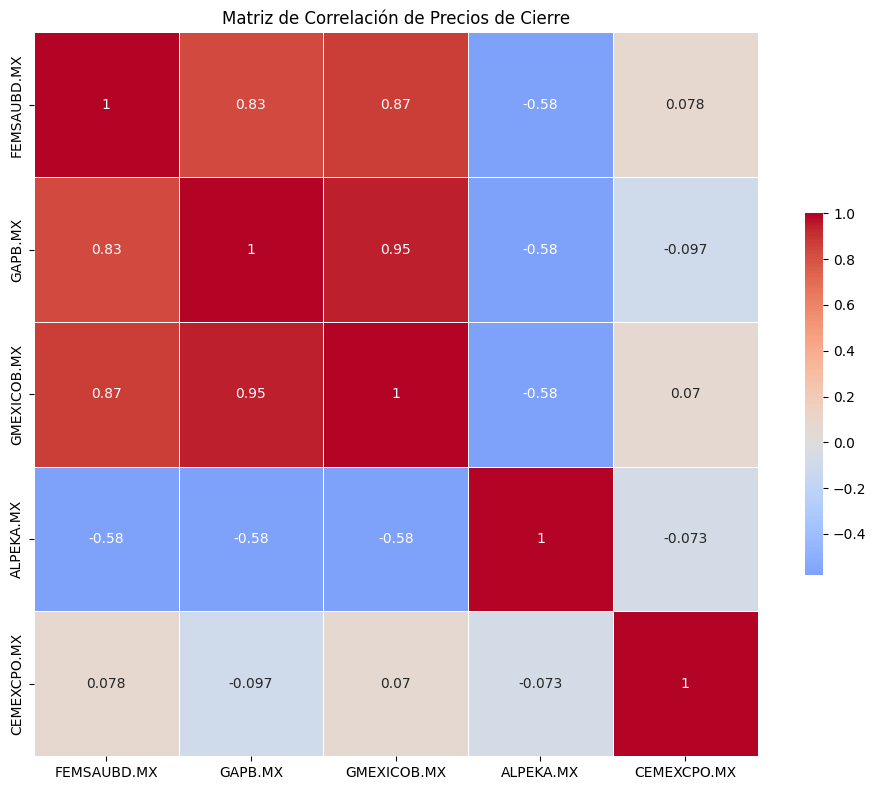

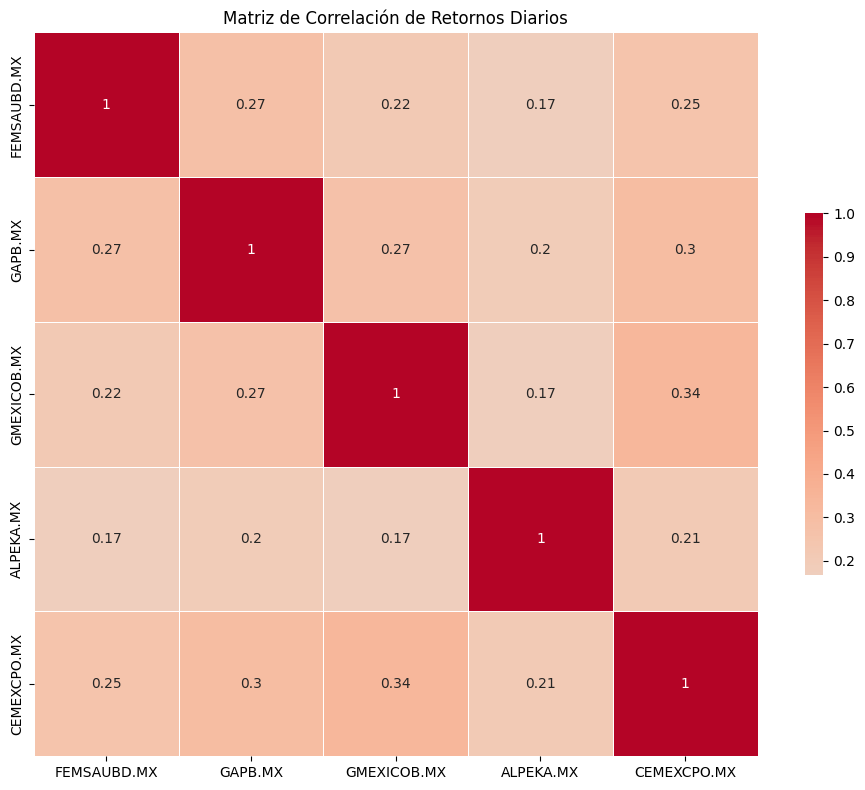


=== ANÁLISIS COMBINADO ===
Descargando datos para 5 tickers...
Descargando FEMSAUBD.MX …
Listo → FEMSAUBD.csv  (6525 filas)
Descargando GAPB.MX …
Listo → GAPB.csv  (4920 filas)
Descargando GMEXICOB.MX …
Listo → GMEXICOB.csv  (6525 filas)
Descargando ALPEKA.MX …
Listo → ALPEKA.csv  (3363 filas)
Descargando CEMEXCPO.MX …
Listo → CEMEXCPO.csv  (6525 filas)
Datos combinados: 27858 filas
Retorno mínimo: -0.9827
Retorno máximo: 1.0000
Retorno promedio: 0.0963
Entrenando modelos para datos combinados...
Training Random Forest...
Training Gradient Boosting...
Training Neural Network...
Training LSTM...
Haciendo predicciones para datos combinados...
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Model Evaluation (Combined):
           MSE      RMSE       MAE  Direction_Accuracy
rf    0.372034  0.609946  0.538644            0.799160
gb    0.336552  0.580131  0.473014            0.817053
nn    1.348476  1.161239  0.794686            0.712069
lstm  0.301057  0.548687  0.414706            0.826547

==

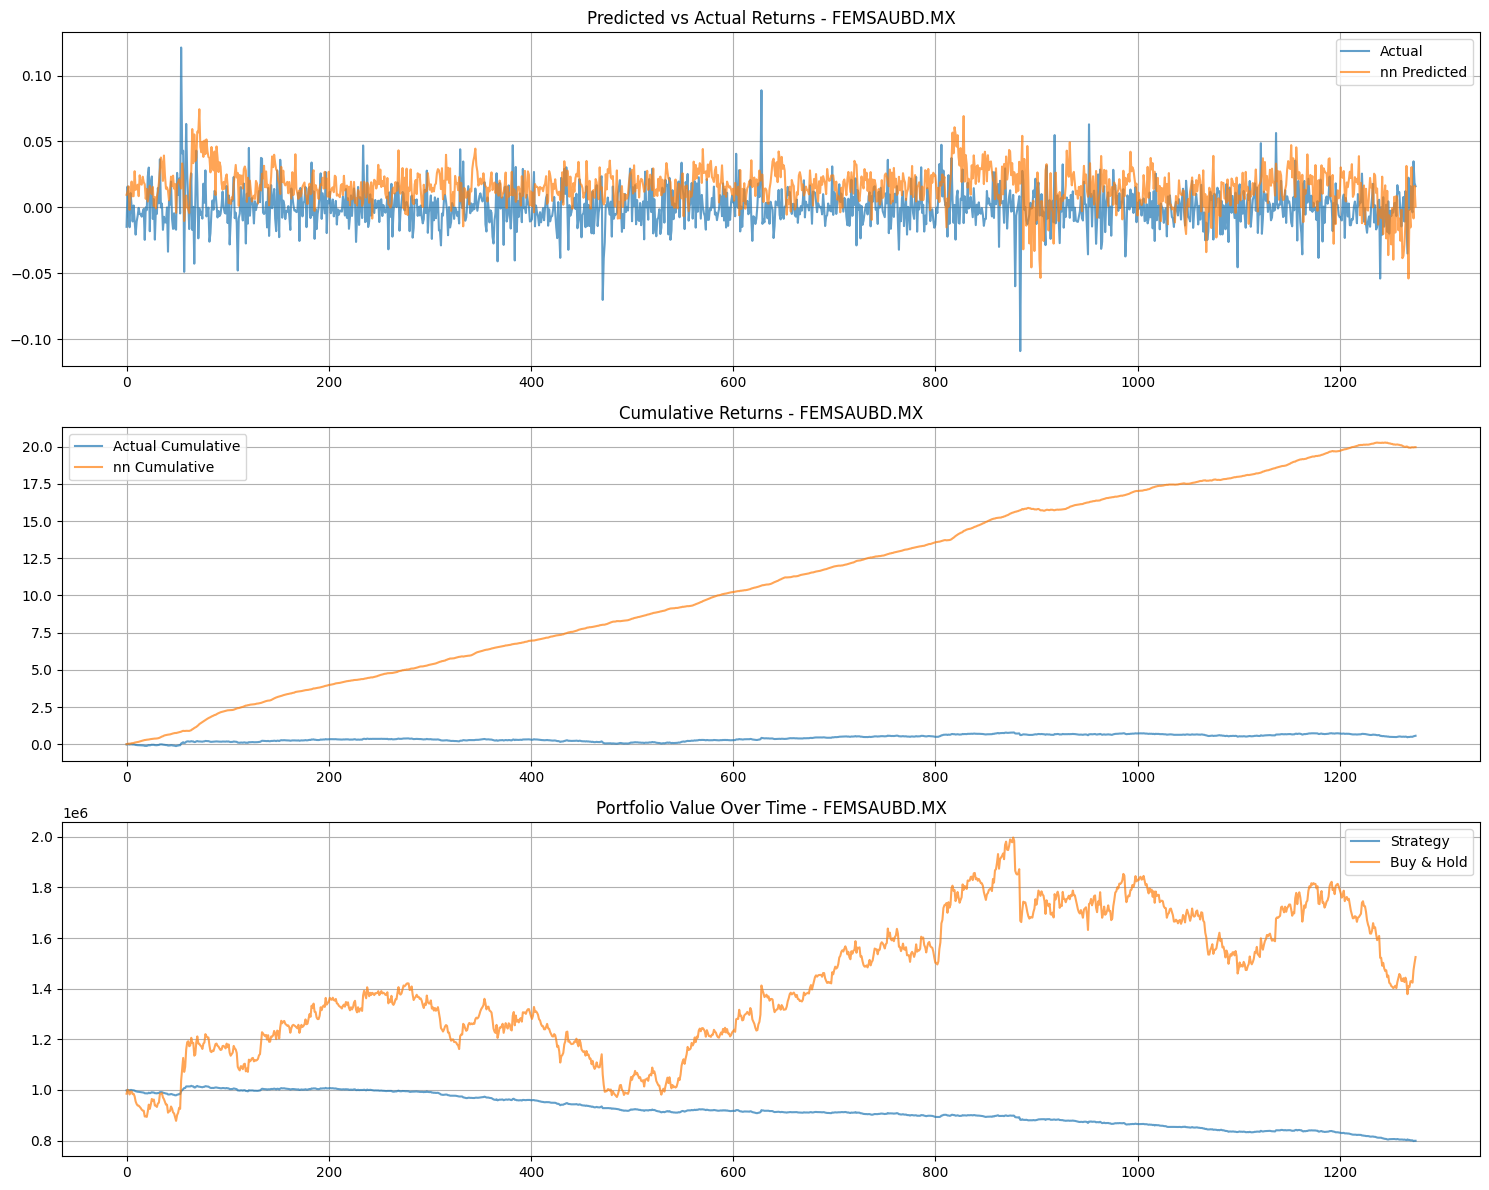


GAPB.MX - gb:
Final Portfolio Value: $773412.51
Total Return: -22.66%
Sharpe Ratio: -1.99
Number of Trades: 953
Buy & Hold Return: 96.31%


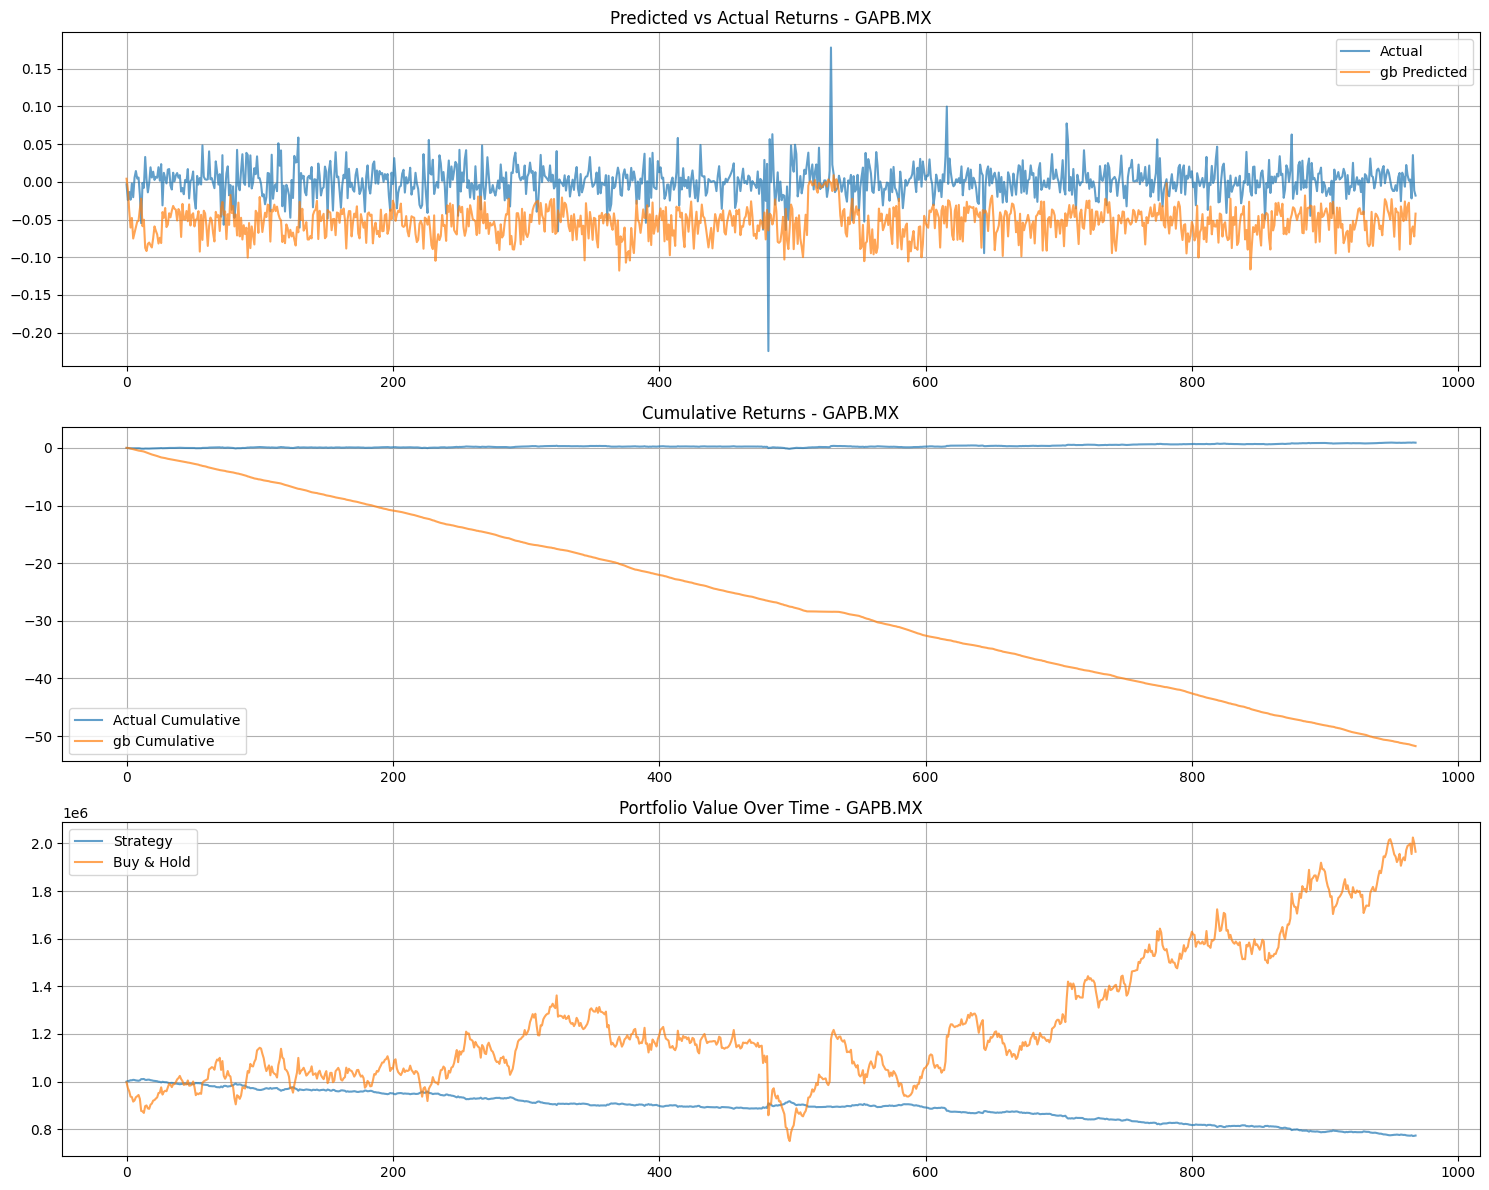


GMEXICOB.MX - gb:
Final Portfolio Value: $974146.82
Total Return: -2.59%
Sharpe Ratio: -0.16
Number of Trades: 807
Buy & Hold Return: 84.74%


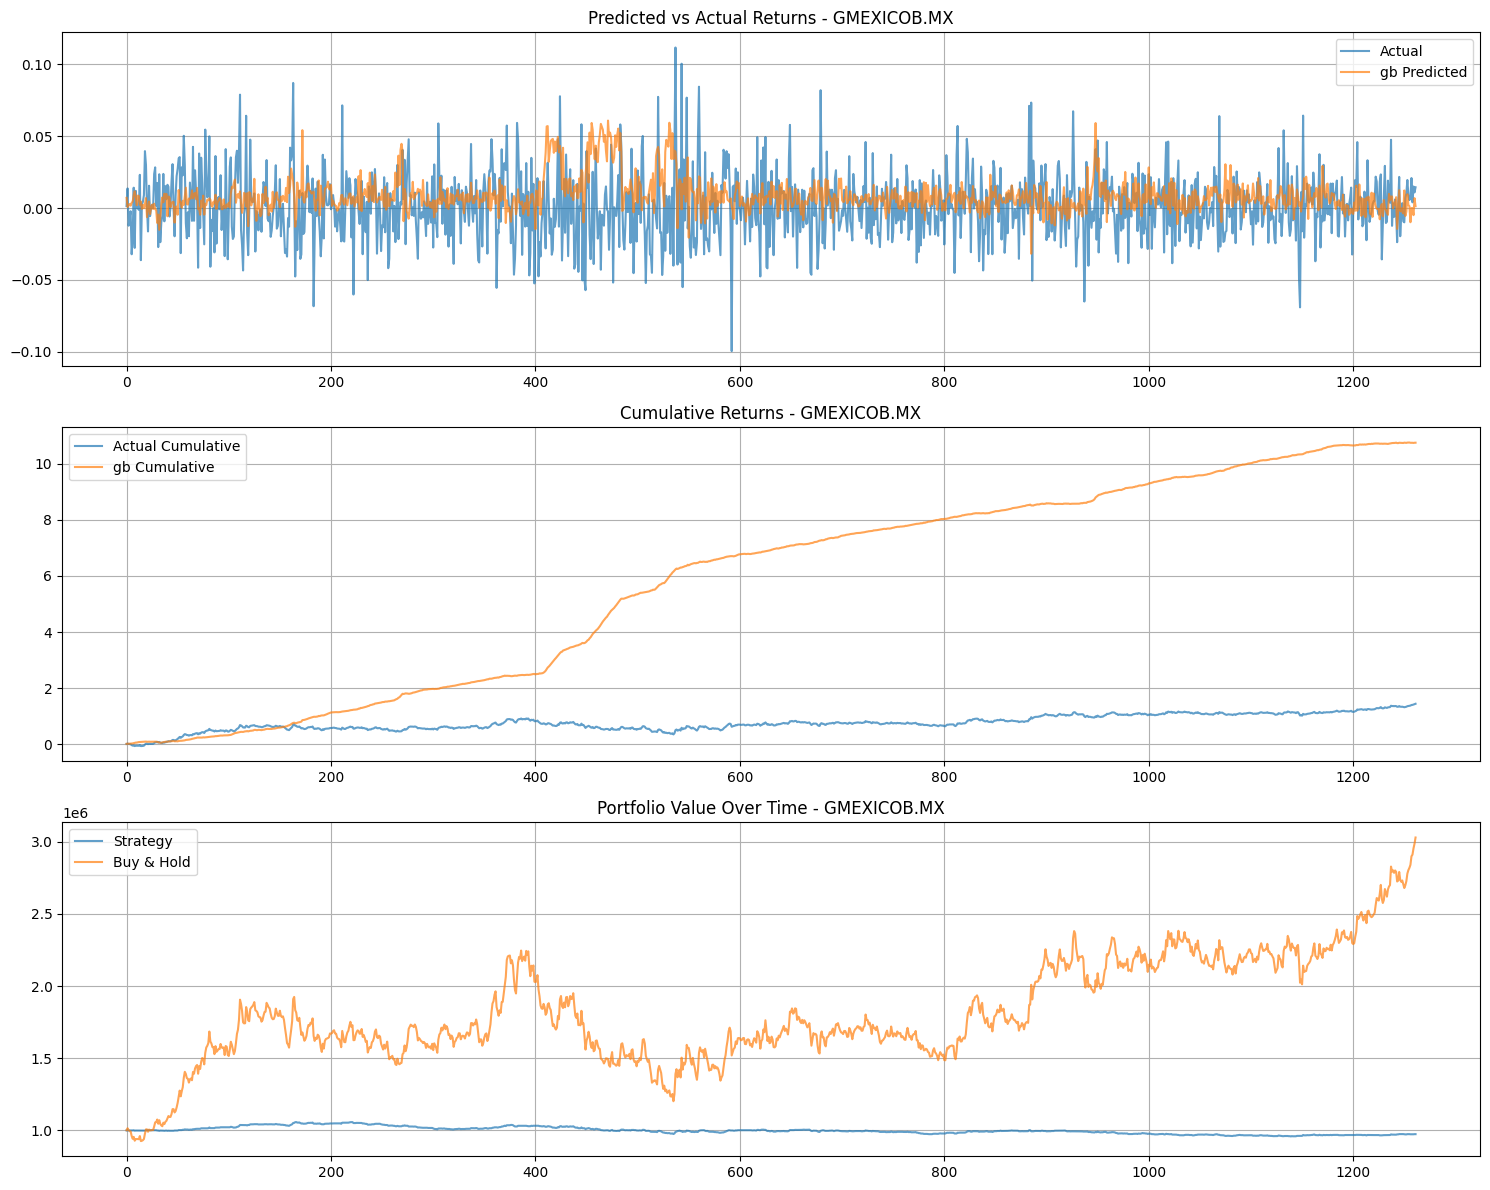


ALPEKA.MX - gb:
Final Portfolio Value: $933753.10
Total Return: -6.62%
Sharpe Ratio: -0.95
Number of Trades: 329
Buy & Hold Return: -63.99%


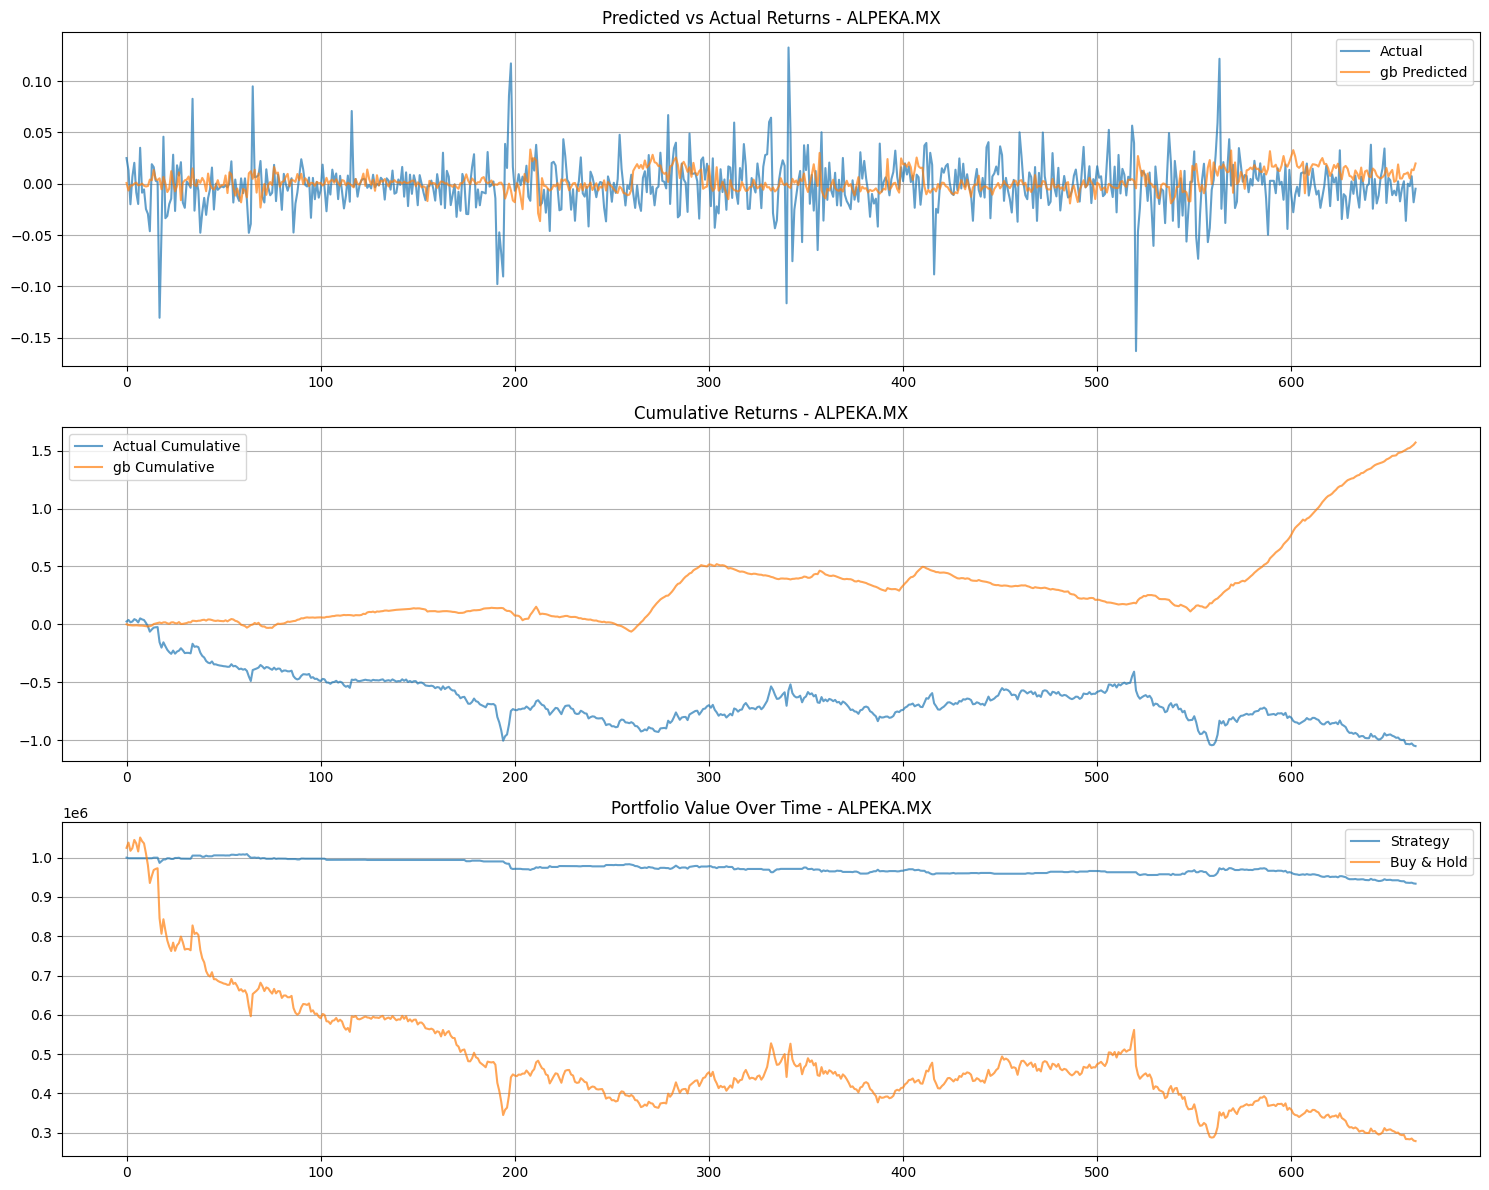


CEMEXCPO.MX - rf:
Final Portfolio Value: $998732.48
Total Return: -0.13%
Sharpe Ratio: -0.47
Number of Trades: 4
Buy & Hold Return: 32.62%


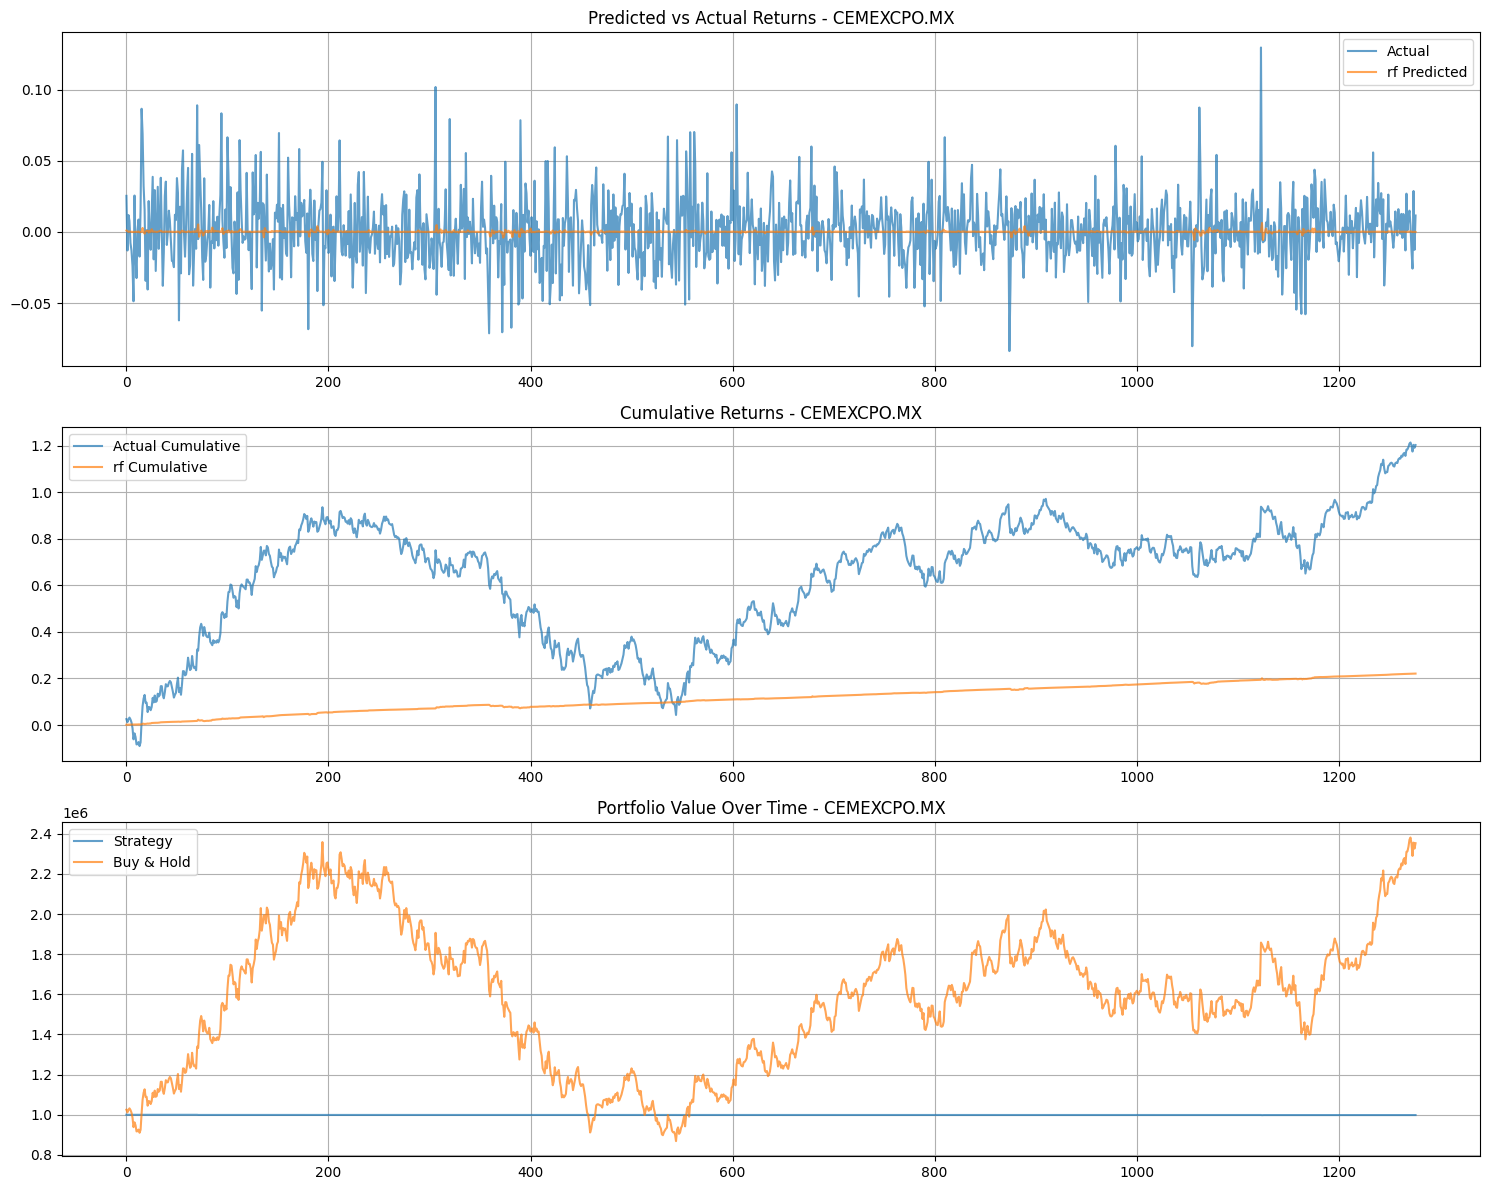


Backtesting Combinado:

Combined - lstm:
Final Portfolio Value: $2088360066509321690767274406380654303170443245408628588915498633334098137236796048972525970766829289399893005926125924088098291747651584.00
Total Return: 208836006650932157161560766848374916523862598257434044235436707944658741336115679453346333375926440048315185115414102628885524905984.00%
Sharpe Ratio: 15.24
Number of Trades: 5463
Buy & Hold Return: -88.82%


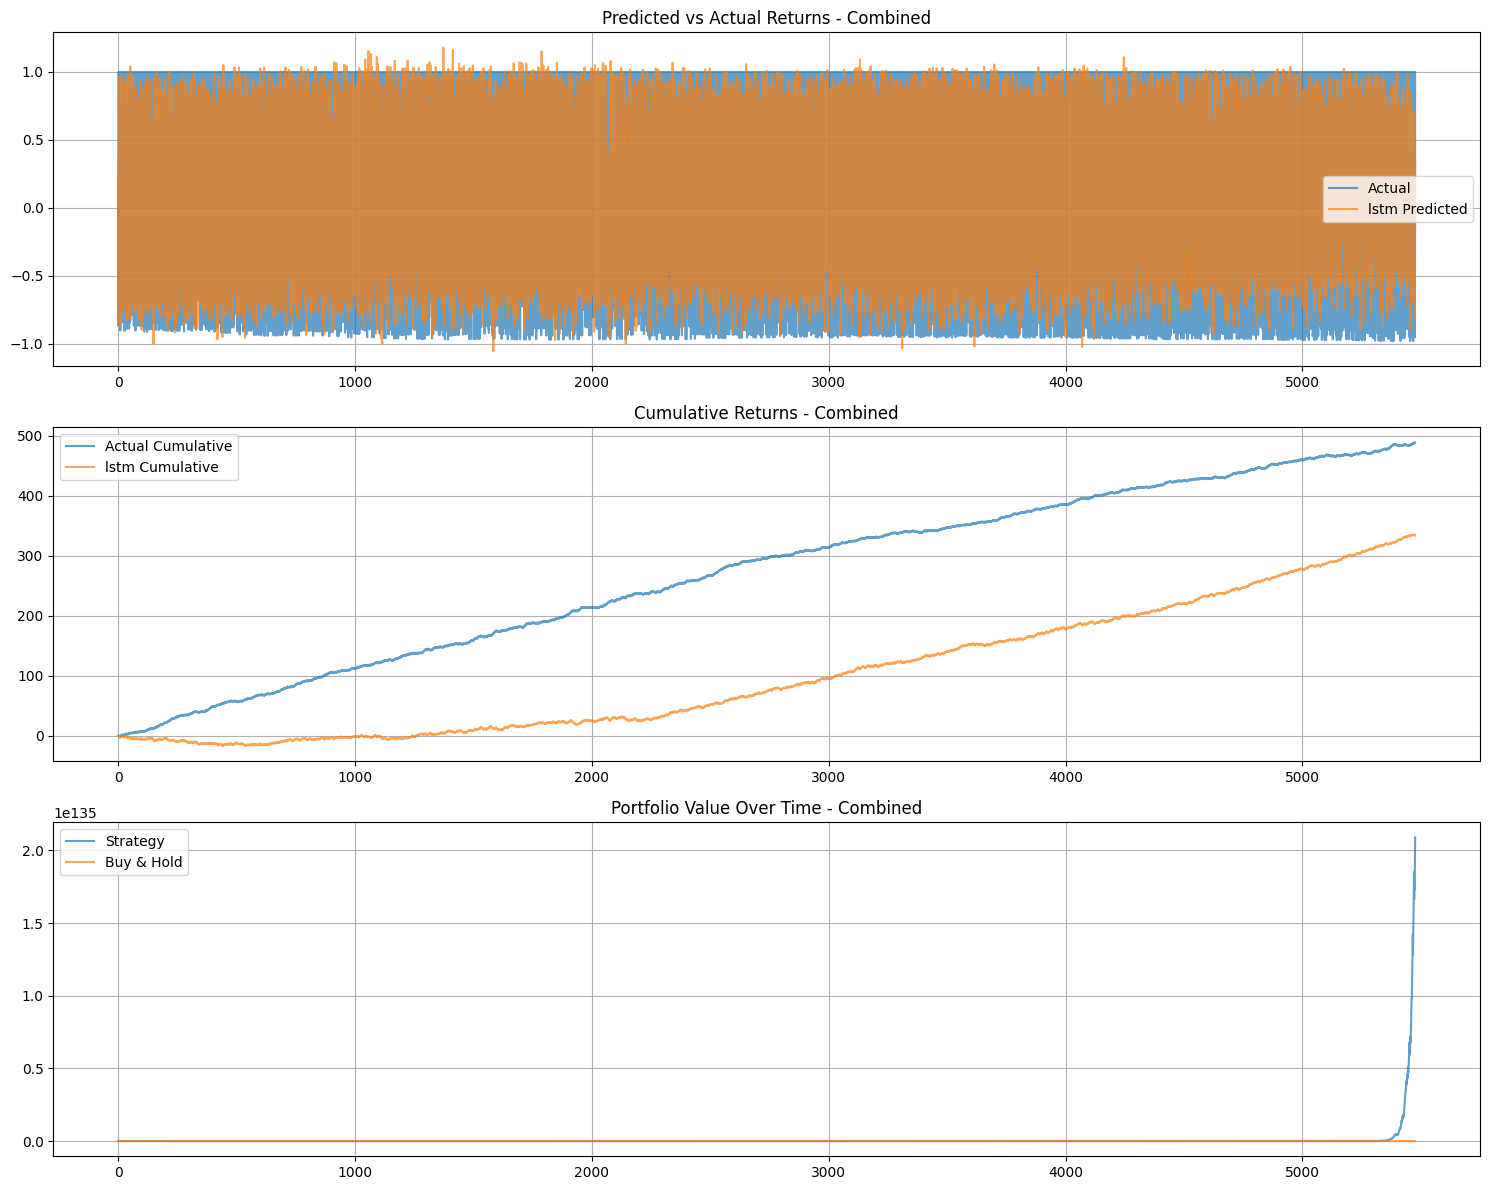

In [9]:
# Usage Example
if __name__ == "__main__":
    # Lista de empresas de la BMV para analizar
    empresas_bmv = [
        "FEMSAUBD.MX",
        "GAPB.MX",
        "GMEXICOB.MX",
        "ALPEKA.MX",
        "CEMEXCPO.MX"
    ]

    # 1. Análisis Individual por Ticker
    print("\n=== ANÁLISIS INDIVIDUAL POR TICKER ===")
    bot_individual = TradingBotML(tickers=empresas_bmv, mode="individual")

    # Crear características
    bot_individual.create_features(lookback=20, forecast_horizon=1)

    # Entrenar modelos
    bot_individual.train_supervised_models()

    # Realizar predicciones
    bot_individual.make_predictions()

    # Evaluar modelos
    individual_results, summary_df = bot_individual.evaluate_models()

    # Analizar correlaciones
    print("\n=== ANÁLISIS DE CORRELACIONES ===")
    correlation_matrix, returns_correlation = bot_individual.analyze_correlations()

    # 2. Análisis Combinado
    print("\n=== ANÁLISIS COMBINADO ===")
    bot_combined = TradingBotML(tickers=empresas_bmv, mode="combined")

    # Crear características
    bot_combined.create_features(lookback=20, forecast_horizon=1)

    # Entrenar modelos
    bot_combined.train_supervised_models()

    # Realizar predicciones
    bot_combined.make_predictions()

    # Evaluar modelos
    combined_results = bot_combined.evaluate_models()

    # 3. Backtesting y Visualización
    print("\n=== BACKTESTING Y VISUALIZACIÓN ===")
    initial_capital = 1000000  # 1 millón como capital inicial

    # Backtesting individual para el mejor modelo de cada ticker
    print("\nBacktesting Individual:")
    for ticker, results in individual_results.items():
        best_model = results['Direction_Accuracy'].idxmax()
        backtest = bot_individual.backtest_strategy_realistic(
            best_model,
            initial_capital=initial_capital,
            ticker=ticker
        )
        print(f"\n{ticker} - {best_model}:")
        print(f"Final Portfolio Value: ${backtest['final_value']:.2f}")
        print(f"Total Return: {backtest['total_return']*100:.2f}%")
        print(f"Sharpe Ratio: {backtest['sharpe_ratio']:.2f}")
        print(f"Number of Trades: {backtest['num_trades']}")
        print(f"Buy & Hold Return: {backtest['buy_hold_return']*100:.2f}%")

        # Graficar resultados
        bot_individual.plot_results(best_model, realistic=True, initial_capital=initial_capital, ticker=ticker)

    # Backtesting combinado para el mejor modelo general
    print("\nBacktesting Combinado:")
    best_model_combined = combined_results['Direction_Accuracy'].idxmax()
    backtest_combined = bot_combined.backtest_strategy_realistic(
        best_model_combined,
        initial_capital=initial_capital
    )
    print(f"\nCombined - {best_model_combined}:")
    print(f"Final Portfolio Value: ${backtest_combined['final_value']:.2f}")
    print(f"Total Return: {backtest_combined['total_return']*100:.2f}%")
    print(f"Sharpe Ratio: {backtest_combined['sharpe_ratio']:.2f}")
    print(f"Number of Trades: {backtest_combined['num_trades']}")
    print(f"Buy & Hold Return: {backtest_combined['buy_hold_return']*100:.2f}%")

    # Graficar resultados combinados
    bot_combined.plot_results(best_model_combined, realistic=True, initial_capital=initial_capital)